# Restaurant Reviews - Sentiment Analysis and Machine Learning

*Ville Kylmämaa, Joona Holappa, Miiro Kuosmanen, Anssi Valjakka*

In [3]:

# Python built-in modules
import sys
import os.path
import json
import subprocess
import shlex
from collections import Counter
from timeit import default_timer as timer

# %pip install pandas
import pandas as pd

# %pip install numpy
import numpy as np

# %pip install nltk
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# %pip install scipy
from scipy.spatial.distance import cosine

# %pip install matplotlib
import matplotlib.pyplot as plt

# %pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# %pip install empath
from empath import Empath

# %pip install wordcloud
from wordcloud import WordCloud

# %pip install tabulate
from IPython.display import Markdown, display

from ast import keyword

from IPython.utils import io

In [5]:

# Read restaurant reviews to pandas dataframe format
reviews_df = pd.read_csv('Restaurant_Reviews.tsv', sep='\t')
print(reviews_df)

# Separate lists for Review and Liked columns
review_column = reviews_df["Review"]
liked_column = reviews_df["Liked"]


                                                Review  Liked
0                             Wow... Loved this place.      1
1                                   Crust is not good.      0
2            Not tasty and the texture was just nasty.      0
3    Stopped by during the late May bank holiday of...      1
4    The selection on the menu was great and so wer...      1
..                                                 ...    ...
995  I think food should have flavor and texture an...      0
996                           Appetite instantly gone.      0
997  Overall I was not impressed and would not go b...      0
998  The whole experience was underwhelming, and I ...      0
999  Then, as if I hadn't wasted enough of my life ...      0

[1000 rows x 2 columns]


In [6]:

print(f"\nThe number of dislike (0) reviews in the data:\n{liked_column.tolist().count(0)}")
print(f"\nThe number of like (1) reviews in the data:\n{liked_column.tolist().count(1)}")



The number of dislike (0) reviews in the data:
500

The number of like (1) reviews in the data:
500


----

### Utility functions

In [7]:

# Use stopwords from nltk
STOPWORDS = list(set(nltk.corpus.stopwords.words('english')))


# Pre-processing: lemmatisation, turn all chars to lowercase, leave out stopwords and words containing numbers
# Returns a list of tokens
def pre_process(doc_string):
    # Tokenize words and turn them to lowercase
    words = word_tokenize(doc_string.lower())

    # Lemmatisation
    words = [WordNetLemmatizer().lemmatize(word, pos="v") for word in words]

    # Leave out stopwords and words containing numbers
    words = [
        word for word in words
        if word.isalpha()
        and word not in STOPWORDS
    ]
    return words


# Progress printing function. Print results in a separate cell, as flushing might delete the result print
def print_progress(completed_items, total_items, elapsed_time):
    eta = (elapsed_time)/completed_items*(total_items - completed_items)
    processed = completed_items/total_items*100.0
    print(f"Progress: {np.round(processed,1)}% ETA: {np.round(eta,1)}s   ", end="\r", flush=True)


# Return 1 if a keyword exists in the given string
def any_keywords_in_string(keywords, row):
    words = word_tokenize(row.lower())
    words = [WordNetLemmatizer().lemmatize(word) for word in words] # Lemmatisation

    if any(keyword in words for keyword in keywords):
        return(1)
    else:
        return(0)


# Printing utility functions
def print_pearson_corr(first_thing_name, second_thing_name, pearson_corr_coeff):
    print(f"Pearson correlation between {first_thing_name} and {second_thing_name}:"
          f"\n{np.round(pearson_corr_coeff[1][0],4)}\n")

def print_cosine_similarity(first_thing_name, second_thing_name, cosine_similarity):
    print(f"Cosine similarity between {first_thing_name} and {second_thing_name}:\n{cosine_similarity}\n")


----

# Task 1

Use initially SentiStrength - sentiment strength detection in short texts - sentiment analysis,
opinion mining (http://sentistrength.wlv.ac.uk/) implementation of sentiment, which provides negative and positive
sentiment score, compute Pearson correlation between this constructed sentiment polarity and the annotation.

In [8]:

# Initialize SentiStrength
# http://sentistrength.wlv.ac.uk/
senti_strength_path = "./sentistrength/SentiStrength.jar"
language_folder_path = "./sentistrength/SentiStrength_Data/"

# Check that the files exist in the given paths
if not os.path.isfile(senti_strength_path):
    print("SentiStrength not found at: ", senti_strength_path)
if not os.path.isdir(language_folder_path):
    print("SentiStrength data folder not found at: ", language_folder_path)

# Returns SentiStrength sentiment score for the given string
def rate_sentiment(sentiString):
    # Open a subprocess using shlex to get the command line string into the correct args list format.
    p = subprocess.Popen(shlex.split("java -jar '" + senti_strength_path + "' stdin sentidata '" + language_folder_path + "'"),
                         stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    # Communicate via stdin the string to be rated. Note that all spaces are replaced with +.
    # Can't send string in Python 3, must send bytes.
    b = bytes(sentiString.replace(" ","+"), 'utf-8')
    stdout_byte, stderr_text = p.communicate(b)
    stdout_text = stdout_byte.decode("utf-8")
    # Remove the tab spacing between the positive and negative ratings. e.g. "1    -5" -> "1 -5"
    stdout_text = stdout_text.rstrip().replace("\t"," ")
    return stdout_text

# Convert the score from 1 -5 to binary: 0 for dislike, 1 for like
# "Neutral" score, for example -2 2, is cast as 0
def score_to_binary(score_original):
    binary_score = score_original.split(' ')
    binary_score = list(binary_score)
    binary_score = [1 if int(binary_score[i]) > abs(int(binary_score[i+1])) else 0 for i in range(0, len(binary_score), 3)]
    return binary_score[0]


In [9]:

# SentiStrength usage example

example_sentence = "'What a lovely day!'"

rated = rate_sentiment(example_sentence)
converted = score_to_binary(rated)

print("\nRating the sentence:")
print(example_sentence)

print("\nRated by SentiStrength:")
print(rated)

print("\nRating converted to 0 for dislike / 1 for like:")
print(converted)



Rating the sentence:
'What a lovely day!'

Rated by SentiStrength:
3 -1

Rating converted to 0 for dislike / 1 for like:
1


In [ ]:

# Collect sentiments evaluated by SentiStrength for each review
# ! Running this takes a few minutes (approximately 3-5min)

sentistrength_sentiments = []
start = timer()
progress = 0

for row in review_column:
    rated_sentiment = rate_sentiment(row)
    converted_sentiment = score_to_binary(rated_sentiment)
    sentistrength_sentiments.append(converted_sentiment)
    progress += 1
    print_progress(progress, len(review_column), timer() - start)


In [ ]:

# Calculate Pearson correlation between the SentimentStrength evaluations and the liked column

pearson_corr_coeff = np.corrcoef(sentistrength_sentiments, liked_column)

print(f"\nPearson correlation coefficient matrix:\n{pearson_corr_coeff}")
print(f"\nPearson correlation between SentiStrength sentiment and review liked score:\n{pearson_corr_coeff[1][0]}")



Pearson correlation coefficient matrix:
[[1.         0.61844668]
 [0.61844668 1.        ]]

Pearson correlation between SentiStrength sentiment and review liked score:
0.618446679812491


----

# Task 2

Repeat this process when considering the correlation of the positive class alone and the correlation of the negative class alone.

In [ ]:

# Calculate overall cosine similarity
overall_cosine_similarity = 1 - cosine(sentistrength_sentiments, liked_column)
print("\nOverall cosine similarity:", overall_cosine_similarity)


# Calculate cosine similarity of positive class alone
positive_sentistrength_sentiments = []
positive_corresponding_liked_column = []

for index, rating in enumerate(sentistrength_sentiments):
    if rating == 1:
        positive_sentistrength_sentiments.append(sentistrength_sentiments[index])
        positive_corresponding_liked_column.append(liked_column[index])

positive_cosine_similarity = 1 - cosine(positive_sentistrength_sentiments, positive_corresponding_liked_column)
print("Positive cosine similarity:", positive_cosine_similarity)


# Calculate cosine similarity of negative class alone
negative_sentistrength_sentiments = []
negative_corresponding_liked_column = []

for index, rating in enumerate(sentistrength_sentiments):
    if rating == 0:
        # Add miniscule amount to the 0 vector to avoid division by 0 in the cosine similarity calculation
        negative_sentistrength_sentiments.append(sentistrength_sentiments[index] + 0.00000000000000001)
        negative_corresponding_liked_column.append(liked_column[index])

negative_cosine_similarity = 1 - cosine(negative_sentistrength_sentiments, negative_corresponding_liked_column)
print("Negative cosine similarity:", negative_cosine_similarity)



Overall cosine similarity: 0.8054517979076083
Positive cosine similarity: 0.9062040726049632
Negative cosine similarity: 0.4497912168198972


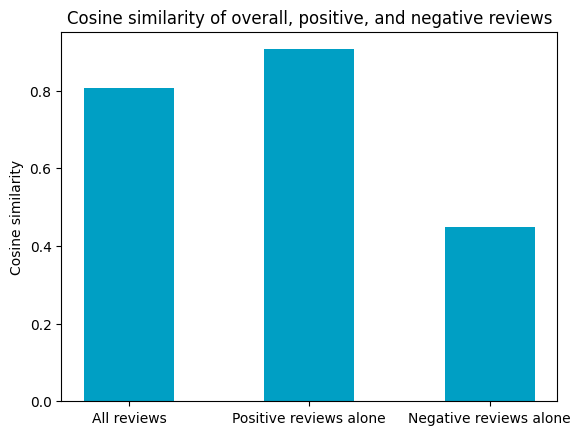

In [ ]:

bar_names = ["All reviews", "Positive reviews alone", "Negative reviews alone"]
bar_values = [overall_cosine_similarity, positive_cosine_similarity, negative_cosine_similarity]

plt.bar(bar_names, bar_values, color ='#009FC4', width = 0.5)

plt.ylabel("Cosine similarity")
plt.title("Cosine similarity of overall, positive, and negative reviews")
plt.show()


----

# Task 3

Now we want to test the correlation with respect to some stylistic aspects of the review. Write a script that estimate
 the number of personal pronouns and number of adjectives and number of adverbs using part-of-speech tagger of your
  choice. Compute both the cosine similarity between each of the above attributes (number of pronouns, number of
   adjectives, number of adverbs) and the annotation.

In [ ]:

pronouns_in_review = []
adjectives_in_review = []
adverbs_in_review = []

# Count the pronouns, adjectives and adverbs in each review and add them to the corresponding lists
for row in review_column:
    pronoun_count = 0
    adjective_count = 0
    adverb_count = 0

    for word in row.split(" "):
        # Part of speech tag, pos_tag reference: https://www.guru99.com/pos-tagging-chunking-nltk.html
        word_pos = pos_tag(word_tokenize(word))

        if word_pos[0][1] == "PRP":
            pronoun_count += 1
        if word_pos[0][1] == "JJ" or word_pos[0][1] == "JJR" or word_pos[0][1] == "JJS":
            adjective_count += 1
        if word_pos[0][1] == "RB" or word_pos[0][1] == "WBR":
            adverb_count += 1

    pronouns_in_review.append(pronoun_count)
    adjectives_in_review.append(adjective_count)
    adverbs_in_review.append(adverb_count)


print("\n---PEARSON CORRELATIONS---\n")
pearson_corr_coeff_pronoun = np.corrcoef(pronouns_in_review, liked_column)
pearson_corr_coeff_adjective = np.corrcoef(adjectives_in_review, liked_column)
pearson_corr_coeff_adverb = np.corrcoef(adverbs_in_review, liked_column)
print_pearson_corr("number of PRONOUNS", "review liked score", pearson_corr_coeff_pronoun)
print_pearson_corr("number of ADJECTIVES", "review liked score", pearson_corr_coeff_adjective)
print_pearson_corr("number of ADVERBS", "review liked score", pearson_corr_coeff_adverb)

print("\n---COSINE SIMILARITIES---\n")
cosine_similarity_pronoun = 1 - cosine(pronouns_in_review, liked_column)
cosine_similarity_adjective = 1 - cosine(adjectives_in_review, liked_column)
cosine_similarity_adverb = 1 - cosine(adverbs_in_review, liked_column)
print_cosine_similarity("number of PRONOUNS", "review liked score", cosine_similarity_pronoun)
print_cosine_similarity("number of ADJECTIVES", "review liked score", cosine_similarity_adjective)
print_cosine_similarity("number of ADVERBS", "review liked score", cosine_similarity_adverb)



---PEARSON CORRELATIONS---

Pearson correlation between number of PRONOUNS and review liked score:
-0.1257

Pearson correlation between number of ADJECTIVES and review liked score:
0.1454

Pearson correlation between number of ADVERBS and review liked score:
-0.111


---COSINE SIMILARITIES---

Cosine similarity between number of PRONOUNS and review liked score:
0.38322825804418215

Cosine similarity between number of ADJECTIVES and review liked score:
0.5314634559571535

Cosine similarity between number of ADVERBS and review liked score:
0.4447081283564944



----

# Task 4

We want to test the hypothesis that the opinion of about the restaurant is constructed according to Price, Quality
 of food served in the restaurant, and friendly staff. Suggest a script that allows you to identify Review that are
  more focused on price, quality of food, friendly staff. You may consider a set of keywords that are most suitable
   to each category and then use simple string matching to match this effect. For each category, generate a binary
    vector indicating whether the given review focuses on the corresponding category.

In [ ]:

with open("keywords.json", "r") as keyword_file:
    keywords = json.loads(keyword_file.read())

price_focus = []
quality_focus = []
staff_focus = []


price_positive_focus = []
quality_positive_focus = []
staff_positive_focus = []

price_negative_focus = []
quality_negative_focus = []
staff_negative_focus = []

# Note: dictionary key has to be same as in keywords.json
keyword_positive_categories = {
    "price_positive": price_positive_focus,
    "quality_positive": quality_positive_focus,
    "staff_positive": staff_positive_focus
    }

keyword_negative_categories = {
    "price_negative": price_negative_focus,
    "quality_negative": quality_negative_focus,
    "staff_negative": staff_negative_focus
}

keyword_all_categories = {
    "price": price_focus,
    "quality": quality_focus,
    "staff": staff_focus
}

keyword_categories = [
    keyword_all_categories,
    keyword_positive_categories,
    keyword_negative_categories
]

for row in review_column:
    for keyword_category_type in keyword_categories:
        for keyword_category in keyword_category_type:
            keyword_category_type[keyword_category].append(
                any_keywords_in_string(keywords[keyword_category],row))


----

# Task 5

Estimate the correlation using Pearson correlation between each vector category and the data annotation.

In [ ]:

rows = []
columns = []
data = []

for index, keyword_category_type in enumerate(keyword_categories):

    if index == 0:
        print("---ALL KEYWORDS---")
        rows.append("All keywords")
    elif index == 1:
        print("---POSITIVE KEYWORDS---")
        rows.append("Positive keywords")
    elif index == 2:
        print("---NEGATIVE KEYWORDS---")
        rows.append("Negative keywords")

    current_column = []
    for keyword_category in keyword_category_type:
        pearson_corr_coeff_temp = np.corrcoef(keyword_category_type[keyword_category], liked_column)
        print_pearson_corr(keyword_category,"liked score", pearson_corr_coeff_temp)
        if(len(columns) < len(keyword_category_type)):
            columns.append(keyword_category)
        current_column.append(np.round(pearson_corr_coeff_temp[1][0],4))
    data.append(current_column)


df = pd.DataFrame(data,columns=columns,index=rows).T
display(Markdown(df.to_markdown()))

---ALL KEYWORDS---
Pearson correlation between price and liked score:
0.0058

Pearson correlation between quality and liked score:
0.1679

Pearson correlation between staff and liked score:
0.0302

---POSITIVE KEYWORDS---
Pearson correlation between price_positive and liked score:
0.0142

Pearson correlation between quality_positive and liked score:
0.2557

Pearson correlation between staff_positive and liked score:
0.1251

---NEGATIVE KEYWORDS---
Pearson correlation between price_negative and liked score:
-0.084

Pearson correlation between quality_negative and liked score:
-0.1601

Pearson correlation between staff_negative and liked score:
-0.0898



|         |   All keywords |   Positive keywords |   Negative keywords |
|:--------|---------------:|--------------------:|--------------------:|
| price   |         0.0058 |              0.0142 |             -0.084  |
| quality |         0.1679 |              0.2557 |             -0.1601 |
| staff   |         0.0302 |              0.1251 |             -0.0898 |

----

# Task 6

We want to revisit the construction of the categories in 4). Instead of string matching, use the semantic
similarity in the following way. Calculate the Wu and Palmer similarity between “price” and the Review (using
the sentence-to-sentence similarity as in labs), repeat this process for the other three categories by suggestion
a representative keyword (s) that will be used to calculate sentence-to-sentence similarity score.

In [ ]:

"""
Functions wup, preProcess, word_similarity and similarity originally by:
Created on Wed Sep 23 07:17:05 2020
@author: Yazid BOUNAB
Yazid.Bounab@oulu.fi
"""

# ! Running this takes a few minutes (approximately 7-9min)

def wup(S1, S2):
    return S1.wup_similarity(S2)


def word_similarity(w1,w2):

    S1 = wn.synsets(w1)
    S2 = wn.synsets(w2)
    if S1 and S2:
       similarity = wup(S1[0], S2[0])
       if similarity:
          return round(similarity,2)
    return 0

def similarity(T1, T2):
    if(len(T1) > 1):
        words1 = pre_process(T1)
    else:
        words1 = word_tokenize(T1)
    if(len(T2) > 1):
        words2 = pre_process(T2)
    else:
        words2 = word_tokenize(T2)
    tf = TfidfVectorizer(use_idf=True)
    if(words1 and words2):
        tf.fit_transform([' '.join(words1), ' '.join(words2)])
    else:
        return 0
    Idf = dict(zip(tf.get_feature_names_out(), tf.idf_))
    Sim = 0
    Sim_score1 = 0
    Sim_score2 = 0

    for w1 in words1:
        Max = 0
        for w2 in words2:
            score = word_similarity(w1,w2)
            if Max < score:
               Max = score
        try:
            Sim_score1 += Max*Idf[w1]
        except KeyError:
            continue

    try:
        Sim_score1 /= sum([Idf[w1] for w1 in words1])
    except KeyError:
        pass
    except ZeroDivisionError:
        Sim_score1 = 0

    for w2 in words2:
        Max = 0
        for w1 in words1:
            score = word_similarity(w1,w2)
            if Max < score:
               Max = score
        try:
            Sim_score2 += Max*Idf[w2]
        except KeyError:
            continue

    try:
        Sim_score2 /= sum([Idf[w2] for w2 in words2])
    except KeyError:
        pass
    except ZeroDivisionError:
        Sim_score2 = 0

    Sim = (Sim_score1+Sim_score2)/2
    return round(Sim,2)

def best_wup_similarity(keywords, row):
    words = word_tokenize(row.lower())
    words = [WordNetLemmatizer().lemmatize(word) for word in words] # Lemmatisation
    string = ""
    for i in words:
        string+=i
        string+=" "
    return max(similarity(keyword, string) for keyword in keywords)

with open("keywords.json", "r") as keyword_file:
    keywords = json.loads(keyword_file.read())


price_focus_wup = []
quality_focus_wup = []
staff_focus_wup = []

price_positive_focus_wup = []
quality_positive_focus_wup = []
staff_positive_focus_wup = []

price_negative_focus_wup = []
quality_negative_focus_wup = []
staff_negative_focus_wup = []

# Note: dictionary key has to be same as in keywords.json
keyword_positive_categories_wup = {
    "price_positive": price_positive_focus_wup,
    "quality_positive": quality_positive_focus_wup,
    "staff_positive": staff_positive_focus_wup
    }

keyword_negative_categories_wup = {
    "price_negative": price_negative_focus_wup,
    "quality_negative": quality_negative_focus_wup,
    "staff_negative": staff_negative_focus_wup
}

keyword_all_categories_wup = {
    "price": price_focus_wup,
    "quality": quality_focus_wup,
    "staff": staff_focus_wup
}

keyword_categories_wup = [
    keyword_all_categories_wup,
    keyword_positive_categories_wup,
    keyword_negative_categories_wup
]


start = timer()
for index, row in enumerate(review_column):
    for keyword_category_type in keyword_categories_wup:
        for keyword_category in keyword_category_type:
            keyword_category_type[keyword_category].append(
                best_wup_similarity(keywords[keyword_category],row))
            print_progress(index + 1, len(review_column),timer() - start)



##### Calculate pearson correlations

In [ ]:

rows = []
columns = []
data = []

for index, keyword_category_type in enumerate(keyword_categories_wup):

    if index == 0:
        print("---ALL KEYWORDS---")
        rows.append("All keywords")
    elif index == 1:
        print("---POSITIVE KEYWORDS---")
        rows.append("Positive keywords")
    elif index == 2:
        print("---NEGATIVE KEYWORDS---")
        rows.append("Negative keywords")

    current_column = []
    for keyword_category in keyword_category_type:
        pearson_corr_coeff_temp = np.corrcoef(keyword_category_type[keyword_category], liked_column)
        print_pearson_corr(keyword_category,"liked score", pearson_corr_coeff_temp)
        if(len(columns) < len(keyword_category_type)):
            columns.append(keyword_category)
        current_column.append(np.round(pearson_corr_coeff_temp[1][0],4))
    data.append(current_column)

df = pd.DataFrame(data,columns=columns,index=rows).T
display(Markdown(df.to_markdown()))


---ALL KEYWORDS---
Pearson correlation between price and liked score:
-0.0574

Pearson correlation between quality and liked score:
0.0355

Pearson correlation between staff and liked score:
-0.0032

---POSITIVE KEYWORDS---
Pearson correlation between price_positive and liked score:
-0.0484

Pearson correlation between quality_positive and liked score:
0.0524

Pearson correlation between staff_positive and liked score:
0.01

---NEGATIVE KEYWORDS---
Pearson correlation between price_negative and liked score:
-0.0641

Pearson correlation between quality_negative and liked score:
-0.0484

Pearson correlation between staff_negative and liked score:
-0.038



|         |   All keywords |   Positive keywords |   Negative keywords |
|:--------|---------------:|--------------------:|--------------------:|
| price   |        -0.0574 |             -0.0484 |             -0.0641 |
| quality |         0.0355 |              0.0524 |             -0.0484 |
| staff   |        -0.0032 |              0.01   |             -0.038  |

----

# Task 7

We want to test another approach for computing the categories by using the empath categories embedding. For this
purpose, re-visit the naming of the empath-categories in GitHub - Ejhfast/empath-client: analyze text with empath
(https://github.com/Ejhfast/empath-client) and select those that might be linked to Price, Quality, Staff friendship.
Write a code that allows you to determine appropriate categories from this embedding and then calculate the correlation
score.  Alternative to manual scrutinization of the Empath categories, you may also generate an empath category
embedding for the keyword “price”, “food quality”, “friendly staff”, and then compute cosine similarity between the
Review embedding vector and each of the above four embedding vectors, so that the one that yields the highest similarity
score will be considered as the one that best represents the underlined category.

In [ ]:



with open("keywords.json", "r") as keyword_file:
    keywords = json.loads(keyword_file.read())
    
lexicon = Empath()

lexicon_size = 50

#Prevents lexicon.create_category from printing
with io.capture_output() as captured:
    # ---All---
    lexicon.create_category("price", keywords["price"], size=lexicon_size)
    lexicon.create_category("quality", keywords["quality"], size=lexicon_size)
    lexicon.create_category("staff", keywords["staff"], size=lexicon_size)

    # ---Positive---
    print("\nPrice category positive:")
    lexicon.create_category("price_positive", keywords["price_positive"], size=lexicon_size)
    lexicon.create_category("quality_positive", keywords["quality_positive"], size=lexicon_size)
    lexicon.create_category("staff_positive", keywords["staff_positive"], size=lexicon_size)

    # ---Negative---
    lexicon.create_category("price_negative", keywords["price_negative"], size=lexicon_size)
    lexicon.create_category("quality_negative", keywords["quality_negative"], size=lexicon_size)
    lexicon.create_category("staff_negative", keywords["staff_negative"], size=lexicon_size)

empath_price = []
empath_quality = []
empath_staff = []

empath_price_positive = []
empath_quality_positive = []
empath_staff_positive = []

empath_price_negative = []
empath_quality_negative = []
empath_staff_negative = []

for row in review_column:
    #all
    empath_price.append(lexicon.analyze(row, categories=["price"], normalize=True).get("price"))
    empath_quality.append(lexicon.analyze(row, categories=["quality"], normalize=True).get("quality"))
    empath_staff.append(lexicon.analyze(row, categories=["staff"], normalize=True).get("staff"))

    #Positive
    empath_price_positive.append(lexicon.analyze(row, categories=["price_positive"], normalize=True).get("price_positive"))
    empath_quality_positive.append(lexicon.analyze(row, categories=["quality_positive"], normalize=True).get("quality_positive"))
    empath_staff_positive.append(lexicon.analyze(row, categories=["staff_positive"], normalize=True).get("staff_positive"))

    #Negative
    empath_price_negative.append(lexicon.analyze(row, categories=["price_negative"], normalize=True).get("price_negative"))
    empath_quality_negative.append(lexicon.analyze(row, categories=["quality_negative"], normalize=True).get("quality_negative"))
    empath_staff_negative.append(lexicon.analyze(row, categories=["staff_negative"], normalize=True).get("staff_negative"))




In [ ]:

print("\n---EMPATH PEARSON CORRELATIONS---\n")
pearson_corr_coeff_empath_price = np.corrcoef(empath_price, liked_column)
pearson_corr_coeff_empath_quality = np.corrcoef(empath_quality, liked_column)
pearson_corr_coeff_empath_staff = np.corrcoef(empath_staff, liked_column)

pearson_corr_coeff_empath_price_positive = np.corrcoef(empath_price_positive, liked_column)
pearson_corr_coeff_empath_quality_positive = np.corrcoef(empath_quality_positive, liked_column)
pearson_corr_coeff_empath_staff_positive = np.corrcoef(empath_staff_positive, liked_column)

pearson_corr_coeff_empath_price_negative = np.corrcoef(empath_price_negative, liked_column)
pearson_corr_coeff_empath_quality_negative = np.corrcoef(empath_quality_negative, liked_column)
pearson_corr_coeff_empath_staff_negative = np.corrcoef(empath_staff_negative, liked_column)
print("\n---All---\n")

print_pearson_corr("Empath PRICE", "review liked score", pearson_corr_coeff_empath_price)
print_pearson_corr("Empath QUALITY", "review liked score", pearson_corr_coeff_empath_quality)
print_pearson_corr("Empath STAFF", "review liked score", pearson_corr_coeff_empath_staff)

print("\n---Positive---\n")
print_pearson_corr("Empath PRICE positive", "review liked score", pearson_corr_coeff_empath_price_positive)
print_pearson_corr("Empath QUALITY positive", "review liked score", pearson_corr_coeff_empath_quality_positive)
print_pearson_corr("Empath STAFF positive", "review liked score", pearson_corr_coeff_empath_staff_positive)

print("\n---Negative---\n")
print_pearson_corr("Empath PRICE negative", "review liked score", pearson_corr_coeff_empath_price_negative)
print_pearson_corr("Empath QUALITY negative", "review liked score", pearson_corr_coeff_empath_quality_negative)
print_pearson_corr("Empath STAFF negative", "review liked score", pearson_corr_coeff_empath_staff_negative)

print("\n---EMPATH COSINE SIMILARITIES---\n")
cosine_sim_empath_price = 1 - cosine(empath_price, liked_column)
cosine_sim_empath_quality = 1 - cosine(empath_quality, liked_column)
cosine_sim_empath_staff = 1 - cosine(empath_staff, liked_column)

cosine_sim_empath_price_positive = 1 - cosine(empath_price_positive, liked_column)
cosine_sim_empath_quality_positive = 1 - cosine(empath_quality_positive, liked_column)
cosine_sim_empath_staff_positive = 1 - cosine(empath_staff_positive, liked_column)

cosine_sim_empath_price_negative = 1 - cosine(empath_price_negative, liked_column)
cosine_sim_empath_quality_negative = 1 - cosine(empath_quality_negative, liked_column)
cosine_sim_empath_staff_negative = 1 - cosine(empath_staff_negative, liked_column)

print("---All---\n")
print_cosine_similarity("Empath PRICE", "review liked score", cosine_sim_empath_price)
print_cosine_similarity("Empath QUALITY", "review liked score", cosine_sim_empath_quality)
print_cosine_similarity("Empath STAFF", "review liked score", cosine_sim_empath_staff)

print("\n---Positive---\n")
print_cosine_similarity("Empath PRICE positive", "review liked score", cosine_sim_empath_price_positive)
print_cosine_similarity("Empath QUALITY positive", "review liked score", cosine_sim_empath_quality_positive)
print_cosine_similarity("Empath STAFF positive", "review liked score", cosine_sim_empath_staff_positive)

print("\n---Negative---\n")
print_cosine_similarity("Empath PRICE negative", "review liked score", cosine_sim_empath_price_negative)
print_cosine_similarity("Empath QUALITY negative", "review liked score", cosine_sim_empath_quality_negative)
print_cosine_similarity("Empath STAFF negative", "review liked score", cosine_sim_empath_staff_negative)



---EMPATH PEARSON CORRELATIONS---


---All---

Pearson correlation between Empath PRICE and review liked score:
-0.0529

Pearson correlation between Empath QUALITY and review liked score:
0.158

Pearson correlation between Empath STAFF and review liked score:
0.1071


---Positive---

Pearson correlation between Empath PRICE positive and review liked score:
-0.043

Pearson correlation between Empath QUALITY positive and review liked score:
0.1897

Pearson correlation between Empath STAFF positive and review liked score:
0.113


---Negative---

Pearson correlation between Empath PRICE negative and review liked score:
0.0302

Pearson correlation between Empath QUALITY negative and review liked score:
-0.093

Pearson correlation between Empath STAFF negative and review liked score:
-0.0464


---EMPATH COSINE SIMILARITIES---

---All---

Cosine similarity between Empath PRICE and review liked score:
0.043795660397513814

Cosine similarity between Empath QUALITY and review liked score:
0.314

----

# Task 8

We want to further emphasize on misclassified reviews. For this purpose, concatenate all reviews for which the
sentiment score is positive while the annotation is zero and those for which the sentiment is zero while the
annotation is 1. Construct the Wordcloud of this dataset. Write a histogram showing the 10 most common wordings
in this dataset. Comment on the findings.

In [10]:

# Collect misclassified ratings
# ! Running this takes a few minutes (approximately 3-5min)

misclassified_reviews = []

start = timer()
for index, row in enumerate(review_column):
    rated_sentiment = rate_sentiment(row)
    converted_sentiment = score_to_binary(rated_sentiment)

    if converted_sentiment != liked_column[index]:
        misclassified_reviews.append([row, liked_column[index]])

    print_progress(index + 1, len(review_column), timer() - start)



Number of misclassified ratings:
191


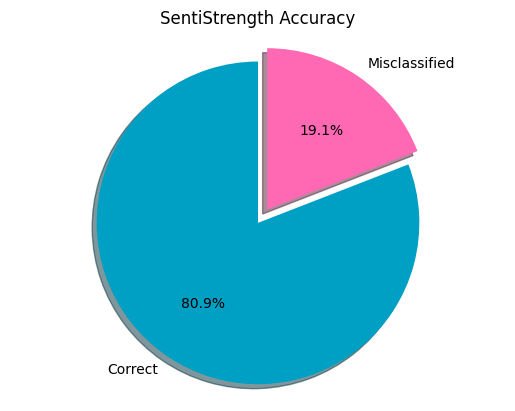

In [9]:

number_of_misclassified = len(misclassified_reviews)
print("\nNumber of misclassified ratings:")
print(number_of_misclassified)

labels = 'Correct', 'Misclassified'
sizes = [1000 - number_of_misclassified, number_of_misclassified]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=("#009FC4", "hotpink"))
ax1.axis('equal')

plt.title("SentiStrength Accuracy")
plt.show()


In [10]:

# Pre-process the collected misclassified ratings
misclassified_reviews_string = ""
for review in misclassified_reviews:
    misclassified_reviews_string += f"{review[0]} "
misclassified_reviews_preprocessed = pre_process(misclassified_reviews_string)

print("\nNumber of word tokens after preprocessing:")
print(len(misclassified_reviews_preprocessed), "\n")

print("Word tokens after preprocessing (print truncated to first 50 elements):")
print(misclassified_reviews_preprocessed[:50], "\n")



Number of word tokens after preprocessing:
1057 

Word tokens after preprocessing (print truncated to first 50 elements):
['potatoes', 'like', 'rubber', 'could', 'tell', 'make', 'ahead', 'time', 'keep', 'warmer', 'service', 'prompt', 'cashier', 'care', 'ever', 'say', 'still', 'end', 'wayyy', 'overprice', 'highly', 'recommend', 'burrittos', 'blah', 'perform', 'like', 'final', 'blow', 'redeem', 'quality', 'restaurant', 'inexpensive', 'deal', 'good', 'enough', 'would', 'drag', 'establishment', 'thing', 'like', 'prime', 'rib', 'dessert', 'section', 'side', 'greek', 'salad', 'greek', 'dress', 'tasty'] 



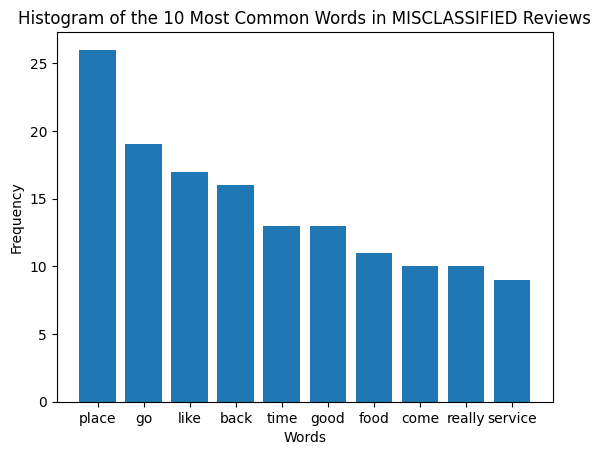

In [11]:

# Collect 10 most common words
most_common_words = Counter(misclassified_reviews_preprocessed).most_common(10)

# Parse the generated tuples into two different arrays
words = [word for word, _ in most_common_words]
counts = [counts for _, counts in most_common_words]

# Plot the words and their frequency
plt.bar(words, counts)
plt.title("Histogram of the 10 Most Common Words in MISCLASSIFIED Reviews")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()



Word cloud of the misclassified reviews:


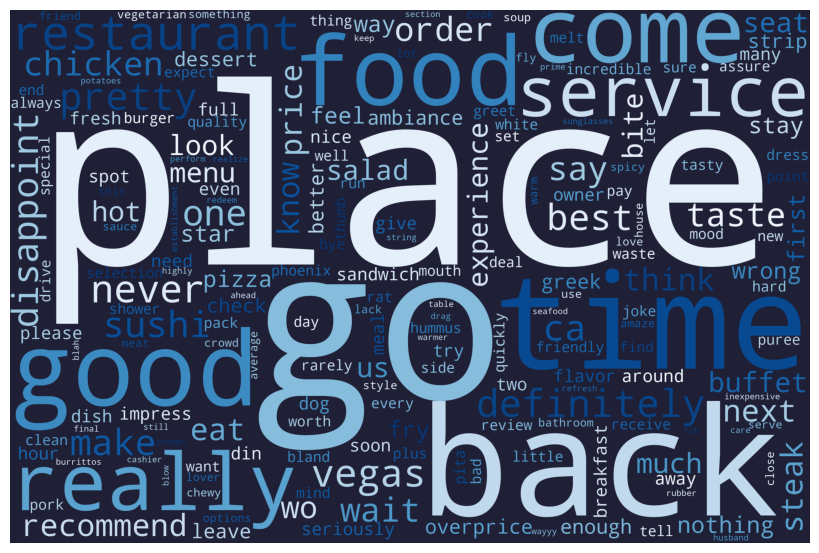

In [12]:

# Generate word cloud of the misclassified reviews

word_cloud = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    background_color="#1f1f36",
    colormap="Blues",
    collocations=False,
).generate(" ".join(misclassified_reviews_preprocessed))

print("\nWord cloud of the misclassified reviews:")

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


In [13]:

print("---Example of a review SentiStrength fails to classify correctly---")

example_misclassification = "'Never again will I be dining at this place!'"

rated = rate_sentiment(example_misclassification)
converted = score_to_binary(rated)

print("\nRating the sentence:")
print(example_misclassification)

print("\nRated by SentiStrength:")
print(rated)

print("\nRating converted to 0 for dislike / 1 for like:")
print(converted)


---Example of a review SentiStrength fails to classify correctly---

Rating the sentence:
'Never again will I be dining at this place!'

Rated by SentiStrength:
2 -1

Rating converted to 0 for dislike / 1 for like:
1


In [14]:

print("---Example 2 of a review SentiStrength fails to classify correctly---")

example_misclassification = "'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.'"

rated = rate_sentiment(example_misclassification)
converted = score_to_binary(rated)

print("\nRating the sentence:")
print(example_misclassification)

print("\nRated by SentiStrength:")
print(rated)

print("\nRating converted to 0 for dislike / 1 for like:")
print(converted)


---Example 2 of a review SentiStrength fails to classify correctly---

Rating the sentence:
'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.'

Rated by SentiStrength:
2 -1

Rating converted to 0 for dislike / 1 for like:
1



Number of word tokens after preprocessing:
5444 

Word tokens after preprocessing (print truncated to first 50 elements):
['wow', 'love', 'place', 'crust', 'good', 'tasty', 'texture', 'nasty', 'stop', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommendation', 'love', 'selection', 'menu', 'great', 'price', 'get', 'angry', 'want', 'damn', 'pho', 'honeslty', 'taste', 'fresh', 'potatoes', 'like', 'rubber', 'could', 'tell', 'make', 'ahead', 'time', 'keep', 'warmer', 'fry', 'great', 'great', 'touch', 'service', 'prompt', 'would', 'go', 'back', 'cashier', 'care'] 



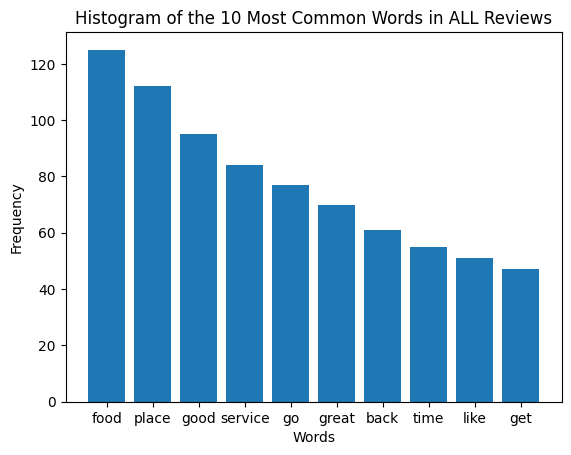


Word cloud of ALL reviews:


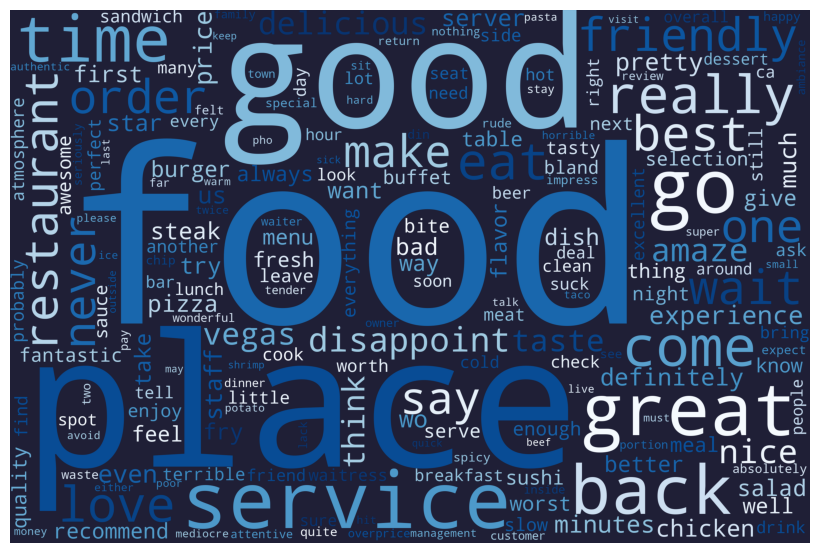

In [15]:

# For comparison, generate histogram and wordcloud of ALL reviews

review_column_string = ""
for review in review_column:
    review_column_string += f"{review} "

review_column_preprocessed = pre_process(review_column_string)

# Collect 10 most common words
most_common_words = Counter(review_column_preprocessed).most_common(10)

print("\nNumber of word tokens after preprocessing:")
print(len(review_column_preprocessed), "\n")

print("Word tokens after preprocessing (print truncated to first 50 elements):")
print(review_column_preprocessed[:50], "\n")

# Parse the generated tuples into two different arrays
words = [word for word, _ in most_common_words]
counts = [counts for _, counts in most_common_words]

# Plot the words and their frequency
plt.bar(words, counts)
plt.title("Histogram of the 10 Most Common Words in ALL Reviews")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()

# Generate word cloud of all reviews
word_cloud = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    background_color="#1f1f36",
    colormap="Blues",
    collocations=False,
).generate(" ".join(review_column_preprocessed))

print("\nWord cloud of ALL reviews:")
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


----

# Task 9.

Now we would like to build a machine learning model for sentiment analysis that takes into account the ambiguous
cases identified in 9). For this purpose, write and script and review the preprocessing and stopword list to not
discard relevant information in the context of sentiment analysis (e.g., avoid discarding negation cues, adjectives
that subsumes polarity and apostrophes, lower-case as capitalization brings emotion,..), then use TfIdfVectorizer
with a maximum feature set of 500, minimum 2 repetition and no more than 60% of word repetition across sentences.
Build this model for one dataset using randomly selected 70% training and 30% testing. Report the classification
accuracy.


### Prepare Training and Testing Data

In [176]:

misclassified_review_column = [review[0] for review in misclassified_reviews]
misclassified_liked_column = [review[1] for review in misclassified_reviews]

# Lemmatisation is the only type of pre-processing used for the machine learning models.
# Removing stopwords discards important negation cues. For example, the word "not" -> "not good" becomes "good".
# Turning the words to lowercase is not used because capitalization brings emotion. For example, FULL CAPITALIZATION.
misclassified_review_column = [WordNetLemmatizer().lemmatize(word) for word in misclassified_review_column]

# Divide the reviews into training and test data
review_train, review_test, liked_train, liked_test = train_test_split(
    misclassified_review_column,
    misclassified_liked_column,
    test_size=0.3
)

# Use tf-idf vectorizer to fit and transform review training data
TFIDF = TfidfVectorizer(max_features=500, max_df=0.60, min_df=2)
tfidf_fit_trans_review = TFIDF.fit_transform(review_train)


### Support Vector Classification Model

In [164]:

# Support vector classification model
svc_model = SVC()

# Train the model with the review column tf-idf fitted and transformed training data, and liked column training data
svc_model.fit(
    tfidf_fit_trans_review,
    liked_train
)

# Make predictions using the model
svc_model_predictions = svc_model.predict(
    TFIDF.transform(review_test)
)

# Get accuracy of the predictions
svc_model_accuracy = accuracy_score(liked_test, svc_model_predictions)

print(f"\nSupport vector classification model accuracy:\n{svc_model_accuracy}")



Support vector classification model accuracy:
0.7758620689655172


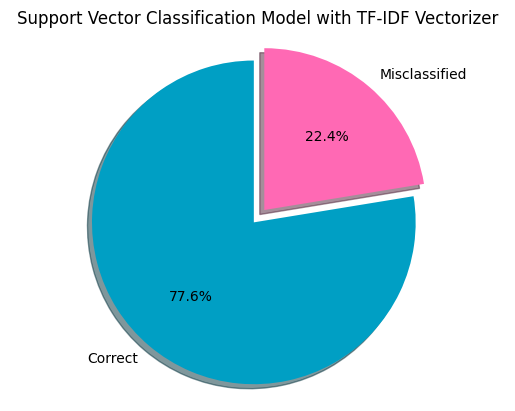

In [165]:

labels = 'Correct', 'Misclassified'
sizes = [svc_model_accuracy, 1 - svc_model_accuracy]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=("#009FC4", "hotpink"))
ax1.axis('equal')

plt.title("Support Vector Classification Model with TF-IDF Vectorizer")
plt.show()


### Logistic Regression Model

In [166]:

# Logistic regression model
log_reg_model = LogisticRegression()

# Train the model with the review column tf-idf fitted and transformed training data, and liked column training data
log_reg_model.fit(
    tfidf_fit_trans_review,
    liked_train
)

# Make predictions using the model
log_reg_model_predictions = log_reg_model.predict(
    TFIDF.transform(review_test)
)

# Get accuracy of the predictions
log_reg_model_accuracy = accuracy_score(liked_test, log_reg_model_predictions)

print(f"\nSupport vector classification model accuracy:\n{log_reg_model_accuracy}")



Support vector classification model accuracy:
0.7241379310344828


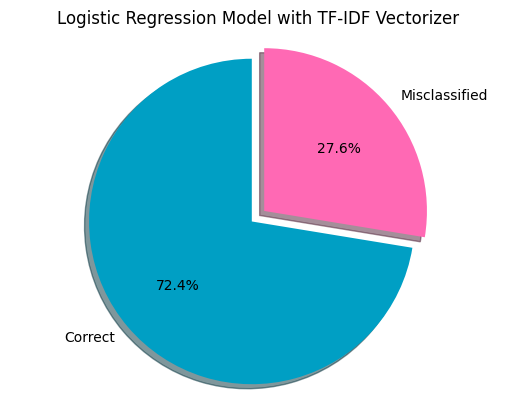

In [167]:

labels = 'Correct', 'Misclassified'
sizes = [log_reg_model_accuracy, 1 - log_reg_model_accuracy]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=("#009FC4", "hotpink"))
ax1.axis('equal')

plt.title("Logistic Regression Model with TF-IDF Vectorizer")
plt.show()


----

# Task 10

Use GloVe embedding instead of TfidfVectorizer, see GloVe: Global Vectors for Word Representation
(https://nlp.stanford.edu/projects/glove/). Use the Glove embedding as feature vectors and test the performance in
the original data (30% test data) and report the classification accuracy on the other two datasets. Comment on the
limitations of the approach

In [13]:

from scipy import spatial

embeddings_dict = {}

# Download pre-trained vectors from https://github.com/stanfordnlp/GloVe
# Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 300d vectors, 822 MB download)
with open("./glove/glove.6B.50d.txt", 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        token = values[0]
        vector = np.array(values[1:], "float32")
        embeddings_dict[token] = vector
file.close()

print("Example global vector embedding for the word 'restaurant':")
print(embeddings_dict["restaurant"])


Example global vector embedding for the word 'restaurant':
[ 0.69607    0.42922   -1.0206     0.20534    0.94613   -0.8808
 -1.391     -0.063854   0.20051    0.067331  -0.69957   -0.44104
  0.41343    0.98698    0.48247   -0.20524    0.015262   0.81055
 -0.16189   -0.57772    1.4103     0.30844   -0.84441    1.4506
 -0.78245   -0.79539   -0.67531    0.87824    0.32835   -0.36903
  2.0142    -0.30928    0.078092   0.97173    0.33983    0.10481
  0.15796    0.5853     0.79749    0.4152     0.22678    0.53758
  0.0064708  0.060384   0.57345    0.28672   -0.91732   -0.74019
  0.81009    0.85844  ]


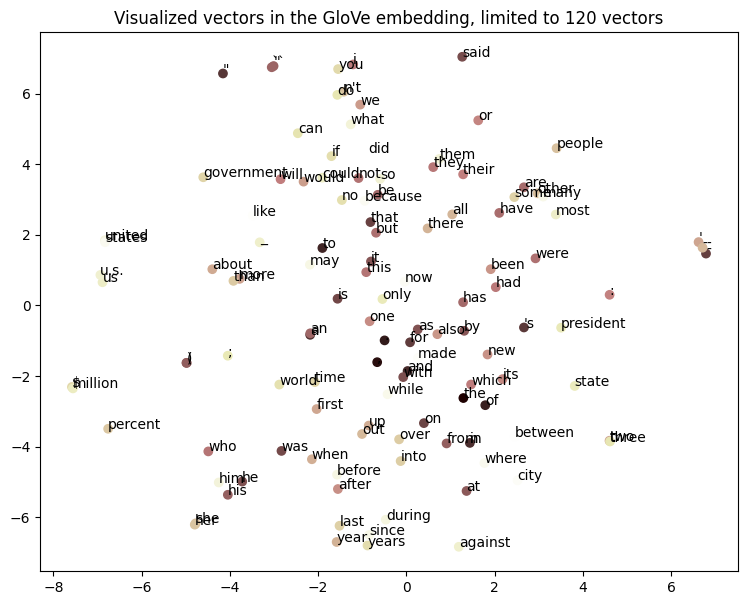

In [14]:

#  Visualiize data in the GloVe embedding
tsne = TSNE(n_components=2, random_state=0, init="random", learning_rate="auto")

tokens = list(embeddings_dict.keys())
vectors = np.array([embeddings_dict[token] for token in tokens])

NUMBER_OF_VECTORS_VISUALIZED = 120
Y = tsne.fit_transform(vectors[:NUMBER_OF_VECTORS_VISUALIZED])

plt.figure(figsize=(9, 7))
plt.title(f"Visualized vectors in the GloVe embedding, limited to {NUMBER_OF_VECTORS_VISUALIZED} vectors")
plt.scatter(Y[:, 0], Y[:, 1], c=np.arange(0, NUMBER_OF_VECTORS_VISUALIZED, 1), cmap="pink")
for label, x, y in zip(tokens, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()


In [15]:

def prepare_sequence(ds, word_to_vec_map):
    traintest_X = []

    for sentence in ds:
        sequence_words = np.zeros((word_to_vec_map['restaurant'].shape))
        for word in sentence.split():
            if word in word_to_vec_map.keys():
                temp_X = word_to_vec_map[word]
            else:
                temp_X = word_to_vec_map['#']
            #print(temp_X)
            sequence_words+=(temp_X)/len(sentence)
            #print(sequence_words)
        traintest_X.append(sequence_words)

    return np.array(traintest_X)


In [16]:

misclassified_review_column_glove = [review[0] for review in misclassified_reviews]
misclassified_liked_column_glove = [review[1] for review in misclassified_reviews]

# Lemmatisation is the only type of pre-processing used for the machine learning models.
# Removing stopwords discards important negation cues. For example, the word "not" -> "not good" becomes "good".
# Turning the words to lowercase is not used because capitalization brings emotion. For example, FULL CAPITALIZATION.
misclassified_review_column_glove = [WordNetLemmatizer().lemmatize(word) for word in misclassified_review_column_glove]

# Divide the reviews into training and test data
review_train, review_test, liked_train, liked_test = train_test_split(
    misclassified_review_column_glove,
    misclassified_liked_column_glove,
    test_size=0.3
)

review_train_glove = prepare_sequence(review_train, embeddings_dict)
validation_review_glove = prepare_sequence(review_test, embeddings_dict)


In [17]:

# Support vector classification model
svc_model_glove = SVC()

# Train the model with the review column tf-idf fitted and transformed training data, and liked column training data
svc_model_glove.fit(
    review_train_glove,
    liked_train
)

# Make predictions using the model
svc_model_glove_predictions = svc_model_glove.predict(
    validation_review_glove
)

# Get accuracy of the predictions
svc_model_glove_accuracy = accuracy_score(liked_test, svc_model_glove_predictions)

print(f"\nSupport vector classification model with GloVe vectorizer accuracy:\n{svc_model_glove_accuracy}")



Support vector classification model with GloVe vectorizer accuracy:
0.5862068965517241


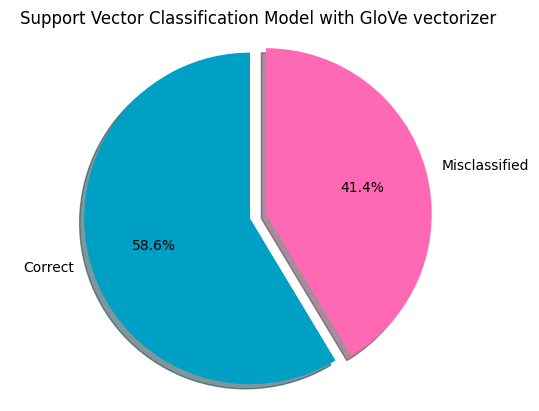

In [18]:

labels = 'Correct', 'Misclassified'
sizes = [svc_model_glove_accuracy, 1 - svc_model_glove_accuracy]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=("#009FC4", "hotpink"))
ax1.axis('equal')

plt.title("Support Vector Classification Model with GloVe vectorizer")
plt.show()


In [19]:

# Logistic regression model
log_reg_model_glove = LogisticRegression()

# Train the model with the review column tf-idf fitted and transformed training data, and liked column training data
log_reg_model_glove.fit(
    review_train_glove,
    liked_train
)

# Make predictions using the model
log_reg_model_glove_predictions = log_reg_model_glove.predict(
    validation_review_glove
)

# Get accuracy of the predictions
log_reg_model_glove_accuracy = accuracy_score(liked_test, log_reg_model_glove_predictions)

print(f"\nLogistic regression classification model accuracy:\n{log_reg_model_glove_accuracy}")



Logistic regression classification model accuracy:
0.5862068965517241


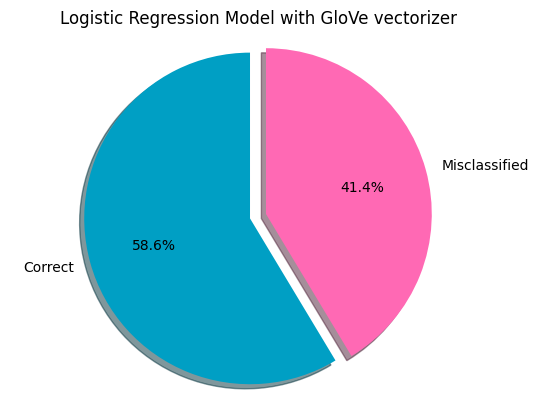

In [20]:

labels = 'Correct', 'Misclassified'
sizes = [log_reg_model_glove_accuracy, 1 - log_reg_model_glove_accuracy]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=("#009FC4", "hotpink"))
ax1.axis('equal')

plt.title("Logistic Regression Model with GloVe vectorizer")
plt.show()


----

# Task 11

Identify appropriate literature to comment on your findings and methodology.


### Sentiment analysis algorithms and applications: A survey

https://www.sciencedirect.com/science/article/pii/S2090447914000550

>Text data are ideally suited for SVM classification because of the sparse nature of text, in which few features are irrelevant, but they tend to be correlated with one another and generally organized into linearly separable categories.

### The Heart and Soul of the Web? Sentiment Strength Detection in the Social Web with SentiStrength​

https://link.springer.com/chapter/10.1007/978-3-319-43639-5_7 ​

### Sentiment Analysis Using Product Review Data​

https://journalofbigdata.springeropen.com/articles/10.1186/s40537-015-0015-2 ​

### A New Similarity Measure for Taxonomy Based on Edge Counting

https://www.researchgate.net/publication/233720775_A_New_Similarity_Measure_for_Taxonomy_Based_on_Edge_Counting

### Machine Learning Techniques for Sentiment Analysis: A Review​

https://www.researchgate.net/profile/Shabib-Aftab-2/publication/317284281_Machine_Learning_Techniques_for_Sentiment_Analysis_A_Review/links/59302d6ba6fdcc89e78431ec/Machine-Learning-Techniques-for-Sentiment-Analysis-A-Review.pdf
